In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch import optim
from torch import autograd
from torch.utils.data import DataLoader, TensorDataset
from torch import nn

import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import transforms as tfs
from torchvision.utils import save_image

from datetime import datetime
from tqdm import tqdm
import os

In [2]:
EPOCH = 250
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
WINDOW_SIZE = 120
LAMDA = 0.01
L = 1024
K = 3
epsilon = 1e-4

# 训练时才会标准化
im_tfs = tfs.Compose([
    # 先将输入归一化到(0,1)，再使用公式”(x-mean)/std”，将每个元素分布到(-1,1) 
    tfs.ToTensor(),
    tfs.Normalize([0.5], [0.5])
])

In [3]:
# 这两个文件的异常区间还比较异常一点
data_path = '~/donut/sample_data/g.csv'
#data_path = '~/donut/sample_data/server_res_eth1out_curve_61.csv'

df = pd.read_csv(data_path)

train_x = np.array(df['value'])
train_l = np.array(df['label'])

print(train_x)

[0.01260368 0.01778577 0.01201359 ... 0.00867589 0.02922801 0.02904138]


In [4]:
sep1 = int(0.6 * len(train_x))
sep2 = int(0.8 * len(train_x))

# 把数据集分成len(data_series) - window_size + 1个window,同时需要有一个flag指示是第几个window
def createWindows(data_series, window_size):
    windows = []
    window_index = []
    for i in range(len(data_series) - window_size + 1):
        window = np.array(data_series[i: i + window_size])
        windows.append(window)
        window_index.append([i])
    return windows, window_index

windows, window_index = createWindows(train_x[:sep1], WINDOW_SIZE)
windows = torch.from_numpy(np.array(windows)).float()
window_index = torch.from_numpy(np.array(window_index)).float()


train_set = TensorDataset(windows, window_index)
train_data = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

for i, batch in enumerate(train_data):
    print(i)
    # batch[0]为数据,batch[1]为标签
    print(batch[0])
    print(batch[1])
    break

torch.multiprocessing.set_sharing_strategy('file_system')

v_windows, v_window_index = createWindows(train_x[sep1:sep2], WINDOW_SIZE)
v_windows = torch.from_numpy(np.array(v_windows)).float()
v_window_index = torch.from_numpy(np.array(v_window_index)).float()

valid_set = TensorDataset(v_windows, v_window_index)
valid_data = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# test_set = TensorDataset(train_x[sep2:], train_y[sep2:])
# test_data = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

0
tensor([[0.0014, 0.0021, 0.0013,  ..., 0.0119, 0.0088, 0.0090],
        [0.0385, 0.0360, 0.0317,  ..., 0.0343, 0.0237, 0.0221],
        [0.1211, 0.1338, 0.1458,  ..., 0.0473, 0.0614, 0.0730],
        ...,
        [0.0046, 0.0019, 0.0017,  ..., 0.0004, 0.0011, 0.0004],
        [0.0537, 0.0667, 0.0504,  ..., 0.0198, 0.0265, 0.0392],
        [0.0499, 0.0518, 0.0517,  ..., 0.1036, 0.0812, 0.0950]])
tensor([[4.2055e+04],
        [9.9221e+04],
        [4.1432e+04],
        [1.1986e+05],
        [7.9108e+04],
        [1.0646e+05],
        [1.0437e+05],
        [1.2464e+05],
        [4.1819e+04],
        [1.1383e+05],
        [1.1904e+05],
        [2.9190e+04],
        [1.1906e+05],
        [4.5950e+04],
        [7.9713e+04],
        [1.0000e+05],
        [8.8650e+04],
        [3.1278e+04],
        [7.8282e+04],
        [5.8510e+03],
        [5.4342e+04],
        [1.4346e+04],
        [5.4700e+02],
        [2.3197e+04],
        [1.1745e+05],
        [6.0822e+04],
        [4.7698e+04],
      

In [5]:
class VAE(nn.Module):
    def __init__(self, input_size=WINDOW_SIZE, output_size=WINDOW_SIZE, latent_num=K, eps=epsilon):
        super(VAE, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.latent_num = latent_num
        self.eps = eps
        
        self.encoder = nn.Sequential(
            nn.Linear(self.input_size, 100),
            #nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            #nn.BatchNorm1d(100),
            nn.ReLU(),
        )
        
        self.mu_layer = nn.Linear(100, self.latent_num)
        self.sigma_layer = nn.Linear(100, self.latent_num)
        
#         self.x2z_mu = nn.Linear(100, latent_num)
#         self.x2z_sigma = F.softplus(F.linear(100, latent_num)) + torch.FloatTensor([eps] * latent_num)
        
#         self.z2x_mu = nn.Linear(100, input_size)
#         self.z2x_sigma = F.softplus(F.linear(100, input_size)) + torch.FloatTensor([eps] * latent_num)
        
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_num, 100),
            #nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            #nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, self.output_size),
            nn.Tanh()
        )
        
    # q(z|x)
    def encode_q(self, x):
        h1 = self.encoder(x)
        mu = self.mu_layer(h1)
        sigma = self.sigma_layer(h1)
        sigma = F.softplus(sigma) + torch.FloatTensor([self.eps] * self.latent_num)
#         x2z_mu = F.linear(h1, self.latent_num)
#         x2z_sigma = F.softplus(F.linear(h1, self.latent_num)) + torch.FloatTensor([self.eps] * self.latent_num)
        return mu, sigma
    
    # 重参数化，使网络可以反向传播
    def reparametrize(self, mu, logvar):
        # mul逐乘
        # exp逐指数
        # exp_是exp的in-place形式
        std = logvar.mul(0.5).exp_()
        ksi = torch.FloatTensor(std.size()).normal_()
        if torch.cuda.is_available():
            ksi = ksi.cuda()
        # z = mu + sigma * ksi
        return ksi.mul(std).add_(mu)
    
    # p(x|z)
    def decoder_p(self, z):
        h2 = self.decoder(z)
        #z2x_mu = F.linear(h2, output_size)
        #z2x_sigma = F.softplus(F.linear(h2, output_size)) + torch.FloatTensor([eps] * output_size)
        return h2

    def forward(self, x):
        mu, logvar = self.encode_q(x)
        z = self.reparametrize(mu, logvar)
        # 解码，同时输出均值和方差
        return self.decoder_p(z), mu, logvar 

In [6]:
net = VAE()
print(net)
if torch.cuda.is_available():
    net = net.cuda()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=120, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (mu_layer): Linear(in_features=100, out_features=3, bias=True)
  (sigma_layer): Linear(in_features=100, out_features=3, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=120, bias=True)
    (5): Tanh()
  )
)


In [7]:
reconstruction_function = nn.MSELoss(reduction='sum')

def loss_function(recon_x, x, mu, logvar):
    MSE = reconstruction_function(recon_x, x)
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return MSE + KLD

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=1e-3) # 添加正则项，替代dropout

nn.utils.clip_grad_norm_(net.parameters(), max_norm=10.0)

# optimizer.param_groups[0]
# 是其中一个参数组，包括['lr']和['weight_decay']
# 可以直接赋值修改参数
# 防止有多个参数组，故使用循环
# def set_learning_rate(optimizer, lr):
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = lr

# 每10轮衰减为原来的75%
def set_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= 0.75

In [8]:
train_losses = []
valid_losses = []

prev_time = datetime.now()

for e in tqdm(range(EPOCH)):
    if e != 0 and e % 10 == 0:
        set_learning_rate(optimizer)
        
    train_loss = 0.0
    for i, batch in enumerate(train_data):
        window = batch[0].view(BATCH_SIZE, -1)
        recon_window, mu, logvar = net(window)
        loss = loss_function(recon_window, window, mu, logvar) / BATCH_SIZE
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # use float() to reduce menmery 'autograd
        train_loss += float(loss)
        
    train_loss /= len(train_data)
    train_losses.append(train_loss)
    
    valid_loss = 0
    
    net.eval()
    
    for i, batch in enumerate(valid_data):
        window = batch[0].view(BATCH_SIZE, -1)
        recon_window, mu, logvar = net(window)
        loss = loss_function(recon_window, window, mu, logvar) / BATCH_SIZE
        valid_loss = float(loss)
        break
        
    valid_losses.append(valid_loss)
        
    if (e + 1) % 5 == 0:
        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        
        prev_time = cur_time
        #print('Epoch: {}, Train Loss: {:.4f} '.format(e + 1, train_loss) + time_str)
        print('Epoch: {}, Train Loss: {:.4f}, Valid Loss: {:.4f} '.format(e + 1, train_loss, valid_loss) + time_str)
    net.train()
    
final_loss = train_losses[-1]

  2%|▏         | 5/250 [00:13<11:45,  2.88s/it]

Epoch: 5, Train Loss: 0.2385, Valid Loss: 0.1625 Time 00:00:13


  4%|▍         | 10/250 [00:34<16:32,  4.14s/it]

Epoch: 10, Train Loss: 0.2383, Valid Loss: 0.1677 Time 00:00:21


  6%|▌         | 15/250 [01:01<19:57,  5.10s/it]

Epoch: 15, Train Loss: 0.2382, Valid Loss: 0.1766 Time 00:00:26


  8%|▊         | 20/250 [01:26<18:47,  4.90s/it]

Epoch: 20, Train Loss: 0.2383, Valid Loss: 0.1850 Time 00:00:25


 10%|█         | 25/250 [01:48<16:32,  4.41s/it]

Epoch: 25, Train Loss: 0.2382, Valid Loss: 0.1900 Time 00:00:21


 12%|█▏        | 30/250 [02:08<14:53,  4.06s/it]

Epoch: 30, Train Loss: 0.2382, Valid Loss: 0.1614 Time 00:00:19


 14%|█▍        | 35/250 [02:27<14:10,  3.95s/it]

Epoch: 35, Train Loss: 0.2382, Valid Loss: 0.1861 Time 00:00:19


 16%|█▌        | 40/250 [02:48<14:14,  4.07s/it]

Epoch: 40, Train Loss: 0.2382, Valid Loss: 0.1900 Time 00:00:20


 18%|█▊        | 45/250 [03:12<16:17,  4.77s/it]

Epoch: 45, Train Loss: 0.2381, Valid Loss: 0.1750 Time 00:00:24


 20%|██        | 50/250 [03:35<15:35,  4.68s/it]

Epoch: 50, Train Loss: 0.2382, Valid Loss: 0.1564 Time 00:00:23


 22%|██▏       | 55/250 [04:10<23:21,  7.19s/it]

Epoch: 55, Train Loss: 0.2382, Valid Loss: 0.1807 Time 00:00:34


 24%|██▍       | 60/250 [04:40<18:44,  5.92s/it]

Epoch: 60, Train Loss: 0.2382, Valid Loss: 0.1828 Time 00:00:29


 26%|██▌       | 65/250 [05:16<23:36,  7.65s/it]

Epoch: 65, Train Loss: 0.2381, Valid Loss: 0.1669 Time 00:00:36


 28%|██▊       | 70/250 [06:05<28:52,  9.63s/it]

Epoch: 70, Train Loss: 0.2381, Valid Loss: 0.1823 Time 00:00:49


 30%|███       | 75/250 [06:59<30:48, 10.57s/it]

Epoch: 75, Train Loss: 0.2381, Valid Loss: 0.1763 Time 00:00:53


 32%|███▏      | 80/250 [07:47<26:59,  9.53s/it]

Epoch: 80, Train Loss: 0.2381, Valid Loss: 0.1725 Time 00:00:48


 34%|███▍      | 85/250 [08:40<28:56, 10.52s/it]

Epoch: 85, Train Loss: 0.2382, Valid Loss: 0.1833 Time 00:00:53


 36%|███▌      | 90/250 [09:34<28:29, 10.68s/it]

Epoch: 90, Train Loss: 0.2381, Valid Loss: 0.1753 Time 00:00:53


 38%|███▊      | 95/250 [10:29<28:15, 10.94s/it]

Epoch: 95, Train Loss: 0.2381, Valid Loss: 0.1780 Time 00:00:55


 40%|████      | 100/250 [11:24<27:32, 11.02s/it]

Epoch: 100, Train Loss: 0.2382, Valid Loss: 0.1711 Time 00:00:55


 42%|████▏     | 105/250 [12:20<26:52, 11.12s/it]

Epoch: 105, Train Loss: 0.2382, Valid Loss: 0.1752 Time 00:00:55


 44%|████▍     | 110/250 [13:15<25:58, 11.14s/it]

Epoch: 110, Train Loss: 0.2381, Valid Loss: 0.1683 Time 00:00:55


 46%|████▌     | 115/250 [14:11<25:00, 11.11s/it]

Epoch: 115, Train Loss: 0.2381, Valid Loss: 0.1719 Time 00:00:55


 48%|████▊     | 120/250 [15:07<24:12, 11.17s/it]

Epoch: 120, Train Loss: 0.2381, Valid Loss: 0.1795 Time 00:00:56


 50%|█████     | 125/250 [16:03<23:30, 11.28s/it]

Epoch: 125, Train Loss: 0.2381, Valid Loss: 0.1952 Time 00:00:56


 52%|█████▏    | 130/250 [16:58<22:06, 11.06s/it]

Epoch: 130, Train Loss: 0.2381, Valid Loss: 0.1753 Time 00:00:55


 54%|█████▍    | 135/250 [17:53<20:50, 10.87s/it]

Epoch: 135, Train Loss: 0.2381, Valid Loss: 0.1828 Time 00:00:54


 56%|█████▌    | 140/250 [18:48<20:19, 11.08s/it]

Epoch: 140, Train Loss: 0.2381, Valid Loss: 0.1759 Time 00:00:55


 58%|█████▊    | 145/250 [19:43<19:17, 11.02s/it]

Epoch: 145, Train Loss: 0.2381, Valid Loss: 0.1613 Time 00:00:54


 60%|██████    | 150/250 [20:40<18:47, 11.28s/it]

Epoch: 150, Train Loss: 0.2381, Valid Loss: 0.1933 Time 00:00:56


 62%|██████▏   | 155/250 [21:36<17:53, 11.30s/it]

Epoch: 155, Train Loss: 0.2381, Valid Loss: 0.2021 Time 00:00:56


 64%|██████▍   | 160/250 [22:33<17:08, 11.43s/it]

Epoch: 160, Train Loss: 0.2381, Valid Loss: 0.1869 Time 00:00:57


 66%|██████▌   | 165/250 [23:30<16:16, 11.49s/it]

Epoch: 165, Train Loss: 0.2381, Valid Loss: 0.1688 Time 00:00:57


 68%|██████▊   | 170/250 [24:28<15:16, 11.46s/it]

Epoch: 170, Train Loss: 0.2382, Valid Loss: 0.1881 Time 00:00:57


 70%|███████   | 175/250 [25:24<14:14, 11.39s/it]

Epoch: 175, Train Loss: 0.2381, Valid Loss: 0.1805 Time 00:00:56


 72%|███████▏  | 180/250 [26:22<13:21, 11.45s/it]

Epoch: 180, Train Loss: 0.2381, Valid Loss: 0.2025 Time 00:00:57


 74%|███████▍  | 185/250 [27:19<12:22, 11.43s/it]

Epoch: 185, Train Loss: 0.2381, Valid Loss: 0.1878 Time 00:00:57


 76%|███████▌  | 190/250 [28:16<11:26, 11.45s/it]

Epoch: 190, Train Loss: 0.2382, Valid Loss: 0.1735 Time 00:00:57


 78%|███████▊  | 195/250 [29:14<10:36, 11.58s/it]

Epoch: 195, Train Loss: 0.2381, Valid Loss: 0.1840 Time 00:00:57


 80%|████████  | 200/250 [30:11<09:26, 11.34s/it]

Epoch: 200, Train Loss: 0.2381, Valid Loss: 0.1695 Time 00:00:56


 82%|████████▏ | 205/250 [31:08<08:34, 11.44s/it]

Epoch: 205, Train Loss: 0.2381, Valid Loss: 0.1768 Time 00:00:57


 84%|████████▍ | 210/250 [32:05<07:40, 11.52s/it]

Epoch: 210, Train Loss: 0.2381, Valid Loss: 0.1839 Time 00:00:57


 86%|████████▌ | 215/250 [33:03<06:45, 11.60s/it]

Epoch: 215, Train Loss: 0.2381, Valid Loss: 0.1853 Time 00:00:57


 88%|████████▊ | 220/250 [34:01<05:47, 11.60s/it]

Epoch: 220, Train Loss: 0.2381, Valid Loss: 0.1662 Time 00:00:57


 90%|█████████ | 225/250 [34:58<04:46, 11.47s/it]

Epoch: 225, Train Loss: 0.2381, Valid Loss: 0.1653 Time 00:00:57


 92%|█████████▏| 230/250 [35:56<03:49, 11.47s/it]

Epoch: 230, Train Loss: 0.2381, Valid Loss: 0.1873 Time 00:00:57


 94%|█████████▍| 235/250 [36:53<02:50, 11.38s/it]

Epoch: 235, Train Loss: 0.2381, Valid Loss: 0.1793 Time 00:00:57


 96%|█████████▌| 240/250 [37:50<01:54, 11.48s/it]

Epoch: 240, Train Loss: 0.2381, Valid Loss: 0.1858 Time 00:00:57


 98%|█████████▊| 245/250 [38:47<00:56, 11.32s/it]

Epoch: 245, Train Loss: 0.2381, Valid Loss: 0.1655 Time 00:00:56


100%|██████████| 250/250 [39:45<00:00, 11.62s/it]

Epoch: 250, Train Loss: 0.2381, Valid Loss: 0.1922 Time 00:00:58


TypeError: 'float' object is not subscriptable

In [9]:
train_loss

0.23813377163756203

In [12]:
final_loss = train_losses[-1]
final_loss

0.23813377163756203

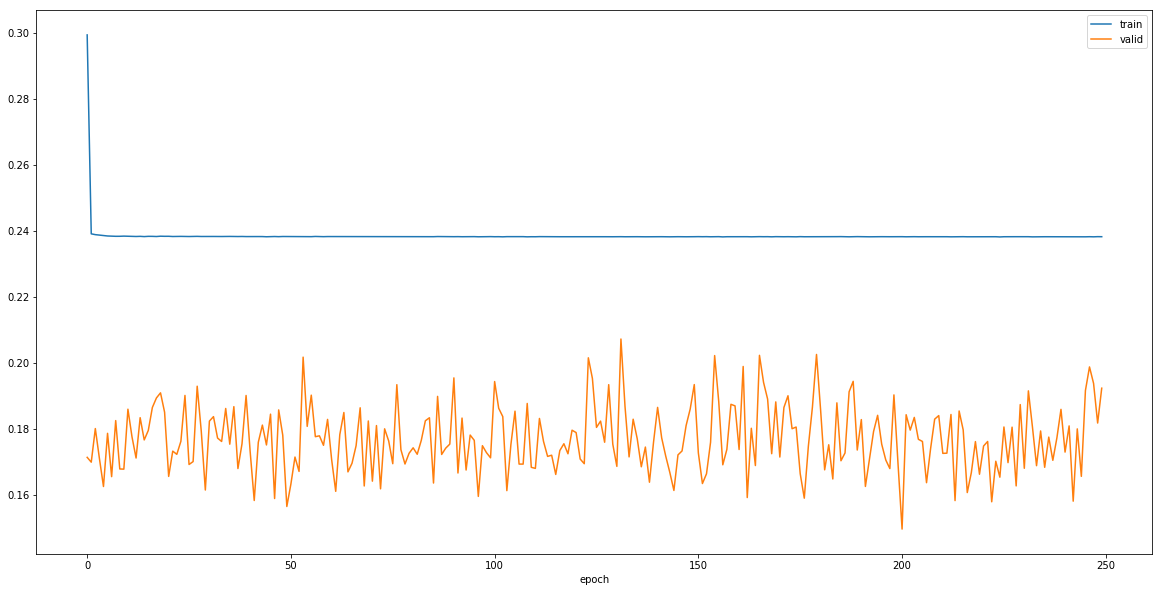

In [10]:
plt.figure(figsize=(20, 10))
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epoch')
plt.legend(loc='best')